In [2]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DCmatch import Match

In [3]:
teams = [i for i in range(10)]
attackStrengths = [0.1*(i+1) for i in range(10)]
defenceStrengths = [0.1*(10-i) for i in range(10)]
homeAdvantage = 1.2

homeAdv = 1.2
rho = 0.5
maxGoals = 7

# simulate 100 games between the teams at random
for i in range(100):
    currentTeams = random.sample(teams, 2)
    homeTeam = currentTeams[0]
    awayTeam = currentTeams[1]
    # simulate match
    match = Match(attackStrengths[homeTeam], defenceStrengths[homeTeam],
                  attackStrengths[awayTeam], defenceStrengths[awayTeam],
                 homeAdv, rho, maxGoals)
    print(match.simulateResult())
    # add match to match DataFrame
    # use Dixon Coles to estimate parameters

[1, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[1, 0]
[0, 0]
[1, 0]
[0, 0]
[0, 1]
[3, 0]
[0, 0]
[0, 0]
[0, 1]
[0, 0]
[0, 0]
[1, 0]
[0, 2]
[0, 1]
[1, 0]
[1, 0]
[2, 0]
[0, 0]
[0, 2]
[0, 0]
[0, 1]
[1, 0]
[1, 0]
[2, 0]
[0, 1]
[0, 0]
[0, 0]
[1, 0]
[0, 0]
[2, 0]
[0, 0]
[0, 0]
[2, 0]
[1, 1]
[2, 0]
[0, 1]
[0, 0]
[0, 0]
[1, 0]
[1, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[1, 0]
[0, 0]
[2, 0]
[0, 0]
[0, 0]
[0, 2]
[0, 0]
[1, 0]
[3, 0]
[2, 0]
[0, 1]
[0, 0]
[1, 0]
[1, 0]
[0, 2]
[0, 0]
[0, 0]
[0, 2]
[1, 0]
[1, 0]
[1, 2]
[0, 0]
[0, 1]
[0, 0]
[0, 0]
[0, 1]
[1, 0]
[0, 1]
[1, 0]
[0, 0]
[0, 0]
[1, 0]
[1, 0]
[1, 0]
[0, 0]
[1, 0]
[0, 0]
[0, 0]
[0, 0]
[1, 1]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[1, 0]
[0, 0]
[0, 0]
[0, 2]
[1, 0]
[0, 0]


In [4]:
homeAttack = 1.2
homeDefence = 0.8
awayAttack = 0.7
awayDefence = 0.7

homeAdv = 1.2
rho = 0.5

match = Match(homeAttack, homeDefence, awayAttack, awayDefence, homeAdv, rho, maxGoals)

In [5]:
match.getScoreMatrix()

[[0.14963, 0.17557, 0.03269, 0.0061, 0.00085, 0.0001, 1e-05],
 [0.26897, 0.05884, 0.03295, 0.00615, 0.00086, 0.0001, 1e-05],
 [0.10591, 0.05931, 0.01661, 0.0031, 0.00043, 5e-05, 0.0],
 [0.03558, 0.01993, 0.00558, 0.00104, 0.00015, 2e-05, 0.0],
 [0.00897, 0.00502, 0.00141, 0.00026, 4e-05, 0.0, 0.0],
 [0.00181, 0.00101, 0.00028, 5e-05, 1e-05, 0.0, 0.0],
 [0.0003, 0.00017, 5e-05, 1e-05, 0.0, 0.0, 0.0]]

In [6]:
match.probJoint(0,0)

0.14962546196097393

In [7]:
match.tau(0, 0)

0.71776

(array([4.816e+03, 3.484e+03, 0.000e+00, 1.333e+03, 0.000e+00, 3.060e+02,
        5.000e+01, 0.000e+00, 1.000e+01, 1.000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

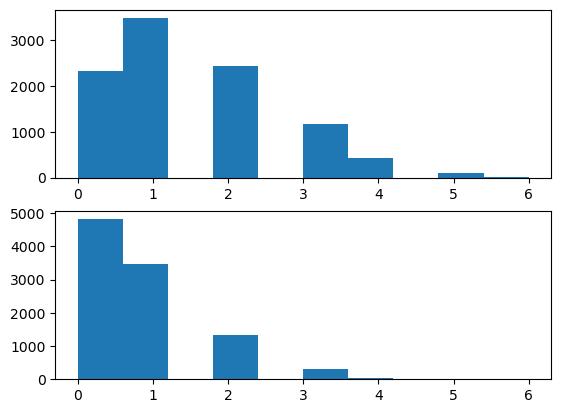

In [8]:
premVSchamp = Match(1.38, 0.68, 1.07, 0.86, 1.2, 0.5, 7)
homeGoals = []
awayGoals = []

for i in range(10000):
    result = premVSchamp.simulateResult()
    homeGoals.append(result[0])
    awayGoals.append(result[1])

fig, ax = plt.subplots(2, 1)
ax[0].hist(homeGoals)
ax[1].hist(awayGoals)

In [21]:
premVSchamp.getOutcomeProbs()

[0.59663, 0.15132000000000004, 0.25132999999999994]

In [23]:
premVSchamp.normaliseProbArray(premVSchamp.getOutcomeProbs())

[0.5970598831158435, 0.15142902890080862, 0.251511087983348]